Pytorch implementation of 
A. Larsen, Autoencoding beyond pixels using a learned similarity metric\
(https://arxiv.org/pdf/1512.09300.pdf)

In [1]:
import time
import torch
from torch import nn, cuda, device, optim
import torchvision as tv
from torch.autograd import Variable
from torchsummary import summary

from matplotlib import pyplot as plt

print(cuda.is_available())
device = device('cuda:0')
print(device)

True
cuda:0


In [2]:
class Encoder(nn.Module):
    def __init__(self, nc, nf, nz):
        super(Encoder, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(nc, nf, 5, 2, 2, bias=False),
            nn.BatchNorm2d(nf),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(nf, nf*2, 5, 2, 2, bias=False),
            nn.BatchNorm2d(nf*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(nf*2, nf*4, 5, 2, 2, bias=False),
            nn.BatchNorm2d(nf*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(in_features=8*8*nf*4, out_features=1024),
            nn.BatchNorm1d(num_features=1024),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.mu = nn.Linear(in_features=1024, out_features=nz)
        self.var = nn.Linear(in_features=1024, out_features=nz)

    def forward(self, input):
        y =  self.net(input)
        return self.mu(y), self.var(y)

In [3]:
class Unflatten(nn.Module):
    def __init__(self, shape):
        super(Unflatten, self).__init__()
        self.shape = shape
        
    def forward(self, input):
        return input.view(len(input), self.shape[0], self.shape[1], self.shape[2])
    
class Decoder(nn.Module):
    def __init__(self, nz):
        super(Decoder, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features=nz, out_features=8*8*nf*4),
            nn.BatchNorm1d(num_features=8*8*nf*4),
            nn.LeakyReLU(0.2, inplace=True),
            Unflatten((256, 8, 8)),
            
            # add output_padding=1 to ConvTranspose2d to reconstruct original size
            nn.ConvTranspose2d(nf*4, nf*2, 5, 2, 2, 1, bias=False),
            nn.BatchNorm2d(nf*2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(nf*2, nf, 5, 2, 2, 1, bias=False),
            nn.BatchNorm2d(nf),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(nf, int(nf/2), 5, 2, 2, 1, bias=False),
            nn.BatchNorm2d(int(nf/2)),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(int(nf/2), nc, 5, 1, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, input):
        return self.net(input)

In [4]:
class Discriminator(nn.Module):
    def __init__(self, nc, nz):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(nc, int(nf/2), 5, 1, 2, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(int(nf/2), nf*2, 5, 2, 2, bias=False),
            nn.BatchNorm2d(nf*2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(nf*2, nf*4, 5, 2, 2, bias=False),
            nn.BatchNorm2d(nf*4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(nf*4, nf*4, 5, 2, 2, bias=False),
            nn.BatchNorm2d(nf*4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Flatten(),
            nn.Linear(in_features=8*8*nf*4, out_features=512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(in_features=512, out_features=1),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.net(input)

In [5]:
batch_size = 128
image_size = 64
dataroot = '/raid/artem/tmp/celeba/'
transform = tv.transforms.Compose([tv.transforms.Resize(image_size),
                                tv.transforms.CenterCrop(image_size),
                                tv.transforms.ToTensor(),
                                tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = tv.datasets.ImageFolder(root=dataroot, transform = transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=8, drop_last=True)
print(len(dataloader))

1582


In [6]:
nf = 64
nc = 3
nz = 128
wd = 1e-5
beta = 0.5

enc = Encoder(nc=nc, nf=nf, nz=nz).to(device)
dec = Decoder(nc=nc, nz=nz).to(device).to(device)
dis = Discriminator(nz=nz).to(device).to(device)

#optimizer_enc = optim.RMSprop(params=Enc.parameters(), lr=3e-4, alpha=0.9)
#optimizer_dec = optim.RMSprop(params=Dec.parameters(), lr=3e-4, alpha=0.9)
#optimizer_dis = optim.RMSprop(params=Dis.parameters(), lr=3e-4, alpha=0.9)
optimizer_dis = optim.Adam(dis.parameters(), lr=1e-3, betas=(beta, 0.999))
optimizer_dec = optim.Adam(dec.parameters(), lr=1e-3, betas=(beta, 0.999))
optimizer_enc = optim.Adam(enc.parameters(), lr=1e-3, betas=(beta, 0.999))

criterion = nn.BCELoss()
criterion_lth = nn.L1Loss()
criterion_rec = nn.MSELoss(reduction='sum')
criterion_kl = nn.KLDivLoss(reduction='sum')

In [7]:
enc_losses = []
dec_losses = []
dis_losses = []

epochs = 5

for epoch in range(1, epochs + 1):
    start = time.time()
    for idx, (data, _) in enumerate(dataloader):
        #if idx == 1: break
        
        batch_size = data.shape[0]
        
        x = Variable(data).to(device)
        
        mu, var = enc(x)
        
        # Reparametrization trick
        epsilon = Variable(torch.randn(mu.shape).to(device))
        z = mu + epsilon * torch.exp(var/2)
        rec = dec(z)

        y_real = Variable(torch.ones(batch_size).to(device))
        dis_real_loss = criterion(dis(x).view(-1), y_real)
        
        y_fake = Variable(torch.zeros(batch_size).to(device))
        dis_rec_loss = criterion(dis(rec).view(-1), y_fake)
        
        zp = Variable(torch.randn(batch_size, nz).to(device))
        xp = dec(zp)
        dis_p_loss = criterion(dis(xp).view(-1), y_fake)
        
        dis.zero_grad()
        dis_loss = dis_real_loss + dis_rec_loss + dis_p_loss
        dis_loss.backward(retain_graph=True)
        optimizer_dis.step()
        dis_losses.append(dis_loss.item())
        
        prior_loss = torch.sum(0.5 * (mu**2 + torch.exp(var) - var - 1))

        # Consider lth layer - last layer
        llike_loss = criterion_lth(dis(x), dis(rec))
        #llike_loss = criterion_rec(x_real, rec)
        enc_loss = prior_loss + llike_loss
        
        enc.zero_grad()
        enc_loss.backward(retain_graph=True)
        optimizer_enc.step()
        enc_losses.append(enc_loss.item())
        
        y_real = Variable(torch.ones(batch_size).to(device))
        dis_loss = criterion(dis(rec).view(-1), y_real)     
        
        dec_loss = llike_loss + dis_loss
        dec.zero_grad()
        dec_loss.backward()
        optimizer_dec.step()
        dec_losses.append(dec_loss.item())
        
        if not (idx % 300):
            print('[%d/%d;%d/%d]: loss_dis: %.3f, loss_dec: %.3f, loss_enc: %.3f'
              % (idx, len(dataloader),
                 (epoch), epochs, 
                 torch.mean(torch.FloatTensor(dis_losses)), 
                 torch.mean(torch.FloatTensor(dec_losses)), 
                 torch.mean(torch.FloatTensor(enc_losses))))
    print('Time: ', time.time() - start)

[0/1582;1/5]: loss_dis: 2.288, loss_dec: 1.647, loss_enc: 2160.342
[300/1582;1/5]: loss_dis: 1.395, loss_dec: 2.070, loss_enc: 96.910
[600/1582;1/5]: loss_dis: 1.129, loss_dec: 2.620, loss_enc: 105.067
[900/1582;1/5]: loss_dis: 1.176, loss_dec: 2.661, loss_enc: 74.008
[1200/1582;1/5]: loss_dis: 1.276, loss_dec: 2.514, loss_enc: 58.403
[1500/1582;1/5]: loss_dis: 1.290, loss_dec: 2.517, loss_enc: 88.222
Time:  1359.5143647193909
[0/1582;2/5]: loss_dis: 1.299, loss_dec: 2.507, loss_enc: 84.000
[300/1582;2/5]: loss_dis: 1.273, loss_dec: 2.568, loss_enc: 71.538
[600/1582;2/5]: loss_dis: 1.270, loss_dec: 2.610, loss_enc: 62.897
[900/1582;2/5]: loss_dis: 1.245, loss_dec: 2.658, loss_enc: 56.379
[1200/1582;2/5]: loss_dis: 1.218, loss_dec: 2.732, loss_enc: 51.229
[1500/1582;2/5]: loss_dis: 1.196, loss_dec: 2.803, loss_enc: 47.106
Time:  1301.8330171108246
[0/1582;3/5]: loss_dis: 1.192, loss_dec: 2.820, loss_enc: 46.072
[300/1582;3/5]: loss_dis: 1.175, loss_dec: 2.881, loss_enc: 42.878
[600/1582

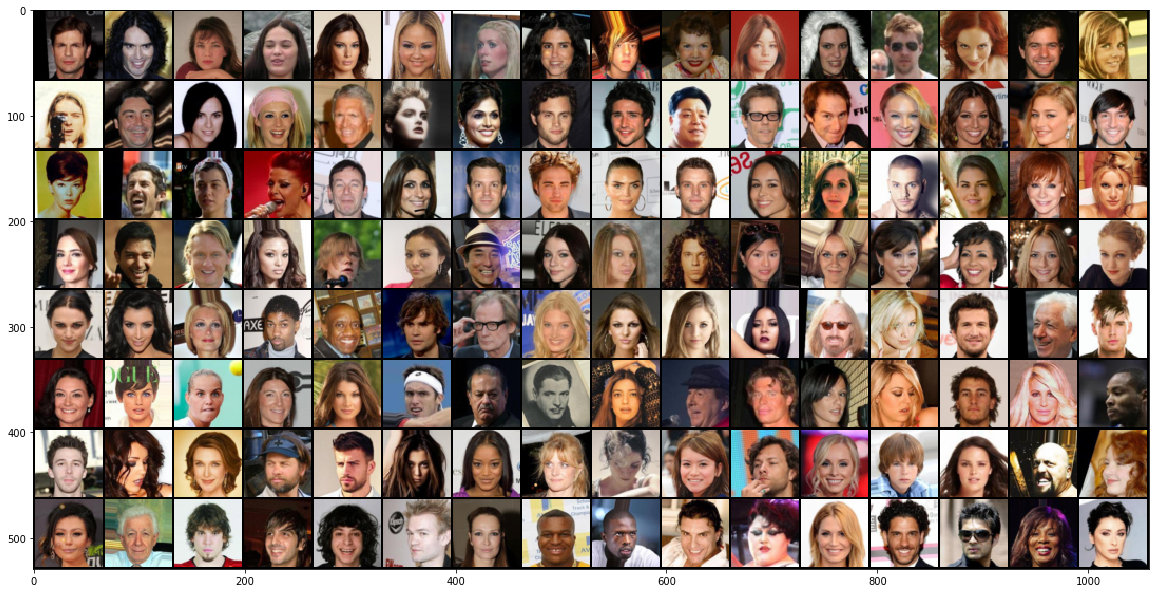

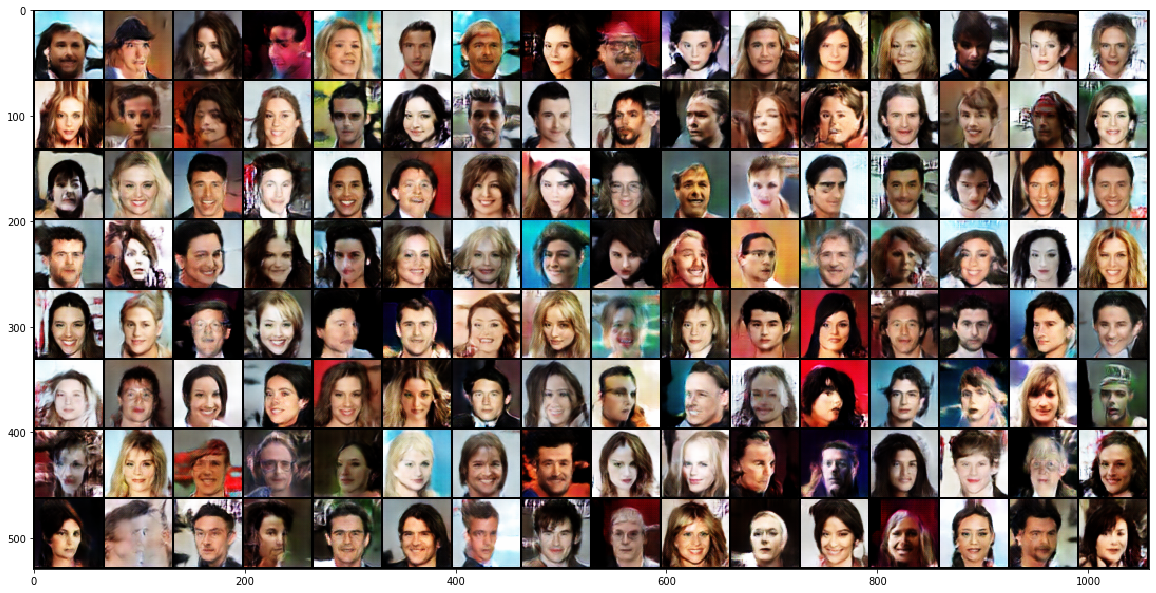

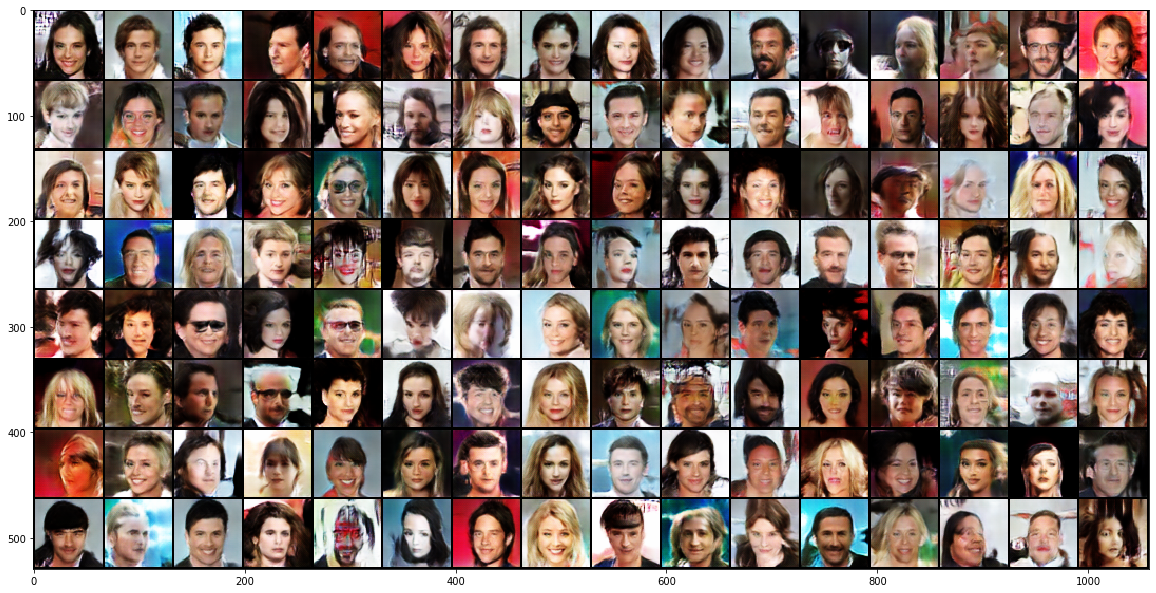

In [10]:
with torch.no_grad():
    idx, (data, label) = next(enumerate(dataloader))
    x = Variable(data).to(device)
    mu, var = enc(x)
    epsilon = Variable(torch.randn(mu.shape).to(device))
    z = mu + epsilon * torch.exp(var/2)
    rec = dec(z)
    y = rec.detach().cpu()
    
    z1 = torch.randn(data.shape[0], nz).to(device)
    rec = dec(z1)
    y1 = rec.detach().cpu()
    
    plt.figure(figsize=(20,20))
    plt.imshow(tv.utils.make_grid(x.detach().cpu(), nrow=16, normalize=True).permute(1, 2, 0))
    plt.show()
    plt.figure(figsize=(20,20))
    plt.imshow(tv.utils.make_grid(y,  nrow=16, normalize=True).permute(1, 2, 0))
    plt.show()
    plt.figure(figsize=(20,20))
    plt.imshow(tv.utils.make_grid(y1,  nrow=16, normalize=True).permute(1, 2, 0))
    plt.show()